In [1]:
#!/usr/bin/python
#-*- coding: utf-8 -*-

# >.>.>.>.>.>.>.>.>.>.>.>.>.>.>.>.
# Licensed under the Apache License, Version 2.0 (the "License")
# You may obtain a copy of the License at
# http://www.apache.org/licenses/LICENSE-2.0

# --- File Name: eval_nav.py
# --- Creation Date: 17-02-2022
# --- Last Modified: Thu 17 Feb 2022 07:03:50 AEDT
# --- Author: Xinqi Zhu
# .<.<.<.<.<.<.<.<.<.<.<.<.<.<.<.<
"""
Visualize variation patterns.
"""
%matplotlib inline

import os

from typing import List
import pickle
import click
import matplotlib.pyplot as plt
import dnnlib
import numpy as np
import torch
import torch.nn.functional as F

import legacy

In [25]:
#navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_mir_hw_mcont_z_dsNeig_ffhq512/00038-ffhq512-z_6-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedE-neig_5-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg160-batch32/network-snapshot-000080.pkl'
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_mir_hw_mcont_z_dsNeig_ffhq512/00041-ffhq512-z_2-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedE-neig_5-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg160-batch32/network-snapshot-000080.pkl'
navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_resnet_ldimg_hw_mcont_neig100_ffhq512/00009-ffhq512-z_32-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_F-ldimg_T-ndup_1-sensor_resnet18-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedE-neig_100-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg160-batch4/network-snapshot-000080.pkl'
device = torch.device('cuda:0')
with open(navigator_pkl, 'rb') as f:
    resume_data = pickle.load(f)
    M = resume_data['M'].requires_grad_(False).to(device)

In [22]:
a = torch.arange(15, dtype=torch.float).view(3,5)
print(a, a.norm(dim=0), a.norm(dim=1))
b = 10 / 3
print(b)
print(repr(b))

tensor([[ 0.,  1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14.]]) tensor([11.1803, 12.5698, 14.0357, 15.5563, 17.1172]) tensor([ 5.4772, 15.9687, 27.0185])
3.3333333333333335
3.3333333333333335


In [123]:
plt.rcParams['figure.figsize'] = [10, 10]
def show_norm(img):
    img = (img - img.min()) / (img.max() - img.min())
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def show_after_tanh(img):
    img = (img + 1) / 2.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def show(img):
    show_norm(img)
    #show_after_tanh(img)

def clip_neg_show(img):
    #img = img.abs()
    img = img.relu()
    show(img)

In [59]:
print(M.mem_dimgs.shape)
dimgs = M.mem_dimgs.unbind(dim=0)
print(dimgs[0].norm(dim=0).max(), dimgs[0].norm(dim=0).min())
print(dimgs[1].norm(dim=0).max(), dimgs[1].norm(dim=0).min())
print(dimgs[1].max(), dimgs[1].min())
to_show = torch.cat(dimgs[-2:], dim=1).cpu()
#show(torch.cat([to_show.relu(), (-to_show).relu(), to_show.abs()], dim=2))
#show(to_show.relu()+(-to_show).relu())
#show(dimgs[-28].cpu().relu())
#clip_neg_show(torch.cat(dimgs[:2], dim=1).cpu())

torch.Size([32, 3, 512, 512])
tensor(4.6995, device='cuda:0') tensor(0.0119, device='cuda:0')
tensor(5.4270, device='cuda:0') tensor(0.0116, device='cuda:0')
tensor(3.2211, device='cuda:0') tensor(-3.1853, device='cuda:0')


In [60]:
navigator_pkl_0 = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_compare_ldimg_3ds/00000-3ds-z_10-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_64-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedES-neig_20-afc_3-nfc_3-atl_10-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg500-batch64/network-snapshot-000500.pkl'
navigator_pkl_1 = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_compare_ldimg_3ds/00001-3ds-z_10-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_64-dic_3-mir_T-ldimg_F-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedES-neig_20-afc_3-nfc_3-atl_10-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg500-batch64/network-snapshot-000500.pkl'

with open(navigator_pkl_0, 'rb') as f:
    resume_data = pickle.load(f)
    M_T = resume_data['M'].requires_grad_(False).to(device)
with open(navigator_pkl_1, 'rb') as f:
    resume_data = pickle.load(f)
    M_F = resume_data['M'].requires_grad_(False).to(device)
print(M_T.mem_dimgs.shape)
dimgs_T = M_T.mem_dimgs.unbind(dim=0)

torch.Size([10, 3, 64, 64])


torch.Size([10, 3, 64, 64])
torch.Size([10, 3, 64, 64])


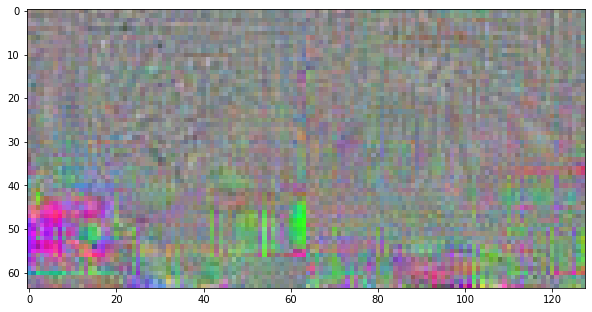

In [136]:
print(M_T.mem_dimgs.shape)
dimgs_T = M_T.mem_dimgs.unbind(dim=0)
print(M_F.mem_dimgs.shape)
dimgs_F = M_F.mem_dimgs.unbind(dim=0)
i = 5
to_show_T = dimgs_T[i].cpu()
to_show_F = dimgs_F[i].cpu()
#show(torch.cat((torch.tanh(to_show_T), torch.tanh(to_show_F)), dim=2))
#show(torch.cat((to_show_T.relu(), to_show_F.relu()), dim=2))
#show(torch.cat((to_show_T.abs(), to_show_F.abs()), dim=2))
show(torch.cat((to_show_T, to_show_F), dim=2))